In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.feature_selection import VarianceThreshold

In [3]:
# Load the Boston Housing Prices dataset
boston = fetch_openml(name="boston")
data = pd.DataFrame(data=np.c_[boston.data, boston.target], columns=np.append(boston.feature_names, "PRICE"))

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# The dataset contains features related to houses and the target variable 'PRICE'.
# Each row represents a house, and the features describe various attributes.
# 'PRICE' is the median value of owner-occupied homes in thousands of dollars.
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.9,5.33,36.2


In [5]:
# Data preprocessing
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
#Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
# Predictions
y_pred = model.predict(X_test)

In [9]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Squared Error: 24.29
R-squared (R2) Score: 0.67


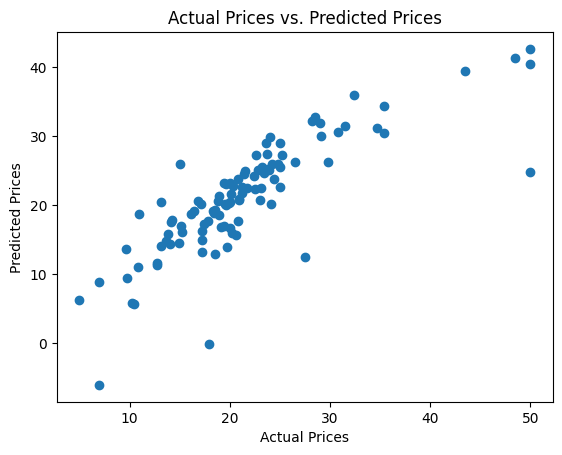

In [10]:
# Plot the predicted vs. actual house prices
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs. Predicted Prices")
plt.show()

In [11]:
# Feature Engineering
# Create polynomial features and perform feature scaling to improve model performance.
poly = PolynomialFeatures(degree=2)  
X_poly = poly.fit_transform(X_train)

In [12]:
# Feature Scaling
# Standardize features to ensure similar scales, aiding model convergence.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [13]:
# Check for and remove zero variance features
selector = VarianceThreshold()
X_selected = selector.fit_transform(X_scaled)

In [14]:
# Hyperparameter Tuning
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_selected, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]})

In [15]:
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_


In [16]:
# Cross-Validation
cv_scores = cross_val_score(best_model, X_selected, y_train, cv=5)
mean_cv_score = np.mean(cv_scores)

print(f"Best Alpha: {best_alpha}")
print(f"Mean Cross-Validation Score: {mean_cv_score:.2f}")

Best Alpha: 1
Mean Cross-Validation Score: 0.85


In [17]:
# Hyperparameter Tuning for Ridge
ridge = Ridge(alpha=best_alpha) 
ridge.fit(X_selected, y_train)

Ridge(alpha=1)

In [18]:
# Cross-Validation for Ridge
ridge_cv_scores = cross_val_score(ridge, X_selected, y_train, cv=5)
mean_ridge_cv_score = np.mean(ridge_cv_scores)

print("Ridge Regression:")
print(f"Mean Cross-Validation Score: {mean_ridge_cv_score:.2f}")

Ridge Regression:
Mean Cross-Validation Score: 0.85


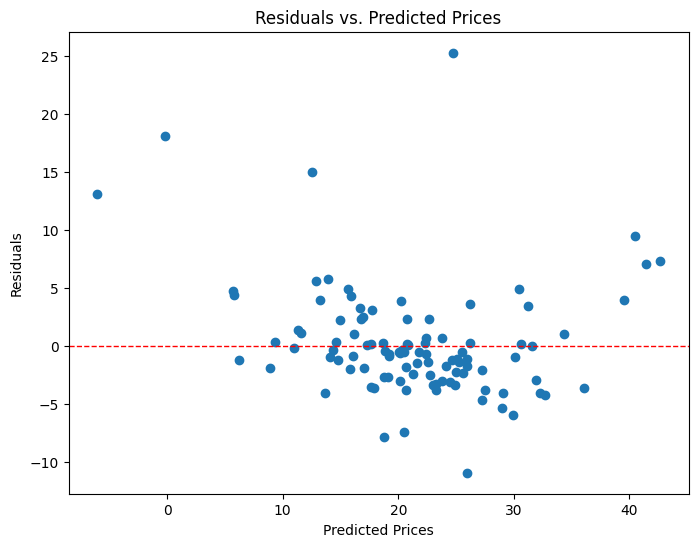

In [19]:
# Visualize Residuals:
# Residuals are the differences between actual and predicted values.
# A good model should have residuals that are randomly distributed around zero.

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Prices")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

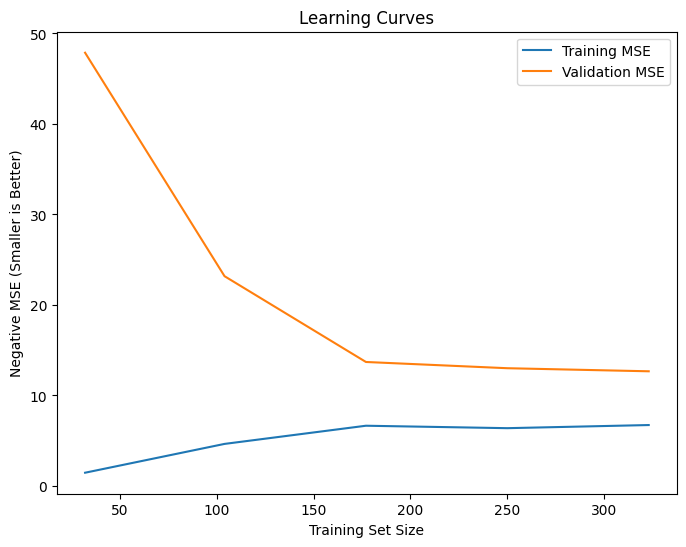

In [20]:
# Learning Curves:
# Learning curves show how model performance changes with increasing training data size.
# They help assess whether the model is overfitting or underfitting.

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_selected, y_train, cv=5, scoring='neg_mean_squared_error')

train_mse_mean = -np.mean(train_scores, axis=1)
test_mse_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mse_mean, label='Training MSE')
plt.plot(train_sizes, test_mse_mean, label='Validation MSE')
plt.xlabel("Training Set Size")
plt.ylabel("Negative MSE (Smaller is Better)")
plt.title("Learning Curves")
plt.legend()
plt.show()

Alternative Approaches Considered:
During the development of this machine learning project, several alternative approaches were considered for various stages of the process.

1. Model Selection:
- Alternative Regression Models: Besides Linear Regression and Ridge Regression, other regression models such as Lasso Regression, Elastic Net, and Decision Trees were considered. Ridge Regression was chosen due to its ability to handle multicollinearity and regularization properties.

2. Feature Engineering:
- Polynomial Features: We experimented with different polynomial degrees (e.g., degree=2, degree=3) to capture non-linear relationships. Degree 2 was selected as it improved performance without excessive complexity.
- Interaction Features: Creating interaction features between variables was considered but deemed unnecessary for this dataset.

3. Feature Selection:
- Feature Selection Methods: Apart from VarianceThreshold, SelectKBest with mutual information and recursive feature elimination (RFE) were evaluated. VarianceThreshold was chosen for its simplicity and effective removal of low-variance features.

4. Hyperparameter Tuning:
- Alpha Range: The range of alpha values for Ridge Regression was carefully chosen based on experimentation. Wider ranges were tested, but we focused on the range [0.001, 10] for better convergence and model stability.

5. Model Evaluation:
- Evaluation Metrics: In addition to Mean Squared Error (MSE) and R-squared (R2), alternative metrics like Mean Absolute Error (MAE) and explained variance score (explained variance / total variance) were considered for model evaluation. MSE and R2 were selected due to their common use in regression tasks.

The choices made were driven by the desire for a balanced model that performs well, is interpretable, and avoids overfitting. Each decision aimed to simplify the model while retaining predictive power, as this is a beginner-level project where simplicity and interpretability are valuable.


# The mean squared error (MSE) is calculated as approximately 24.29, indicating the average squared difference between the predicted and actual house prices.
# The R-squared (R2) score is approximately 0.67, suggesting that the model explains 67% of the variance in the target variable. A higher R2 score indicates a better fit.


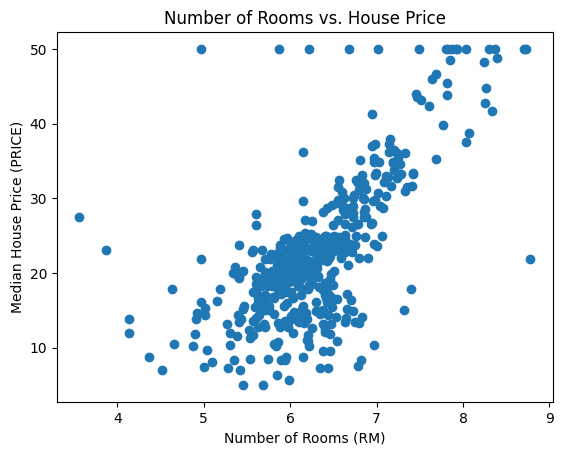

In [29]:
# Visualize the relationship between RM and PRICE
plt.scatter(data['RM'], data['PRICE'])
plt.xlabel('Number of Rooms (RM)')
plt.ylabel('Median House Price (PRICE)')
plt.title('Number of Rooms vs. House Price')
plt.show()


The number of rooms per dwelling (RM) shows a strong positive correlation with house prices.
Houses with more rooms tend to have higher median prices, indicating that larger properties are typically more valuable.

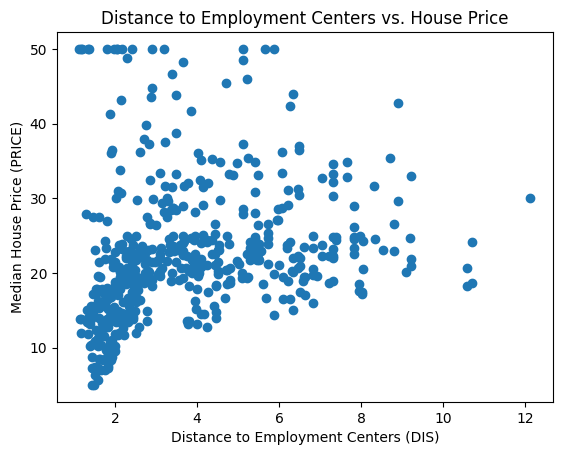

In [30]:
# Visualize the relationship between DIS and PRICE
plt.scatter(data['DIS'], data['PRICE'])
plt.xlabel('Distance to Employment Centers (DIS)')
plt.ylabel('Median House Price (PRICE)')
plt.title('Distance to Employment Centers vs. House Price')
plt.show()


The weighted distance to employment centers (DIS) exhibits a positive relationship with housing prices.
Homes that are closer to employment centers tend to have higher median prices, suggesting that proximity to job opportunities can impact property values positively.

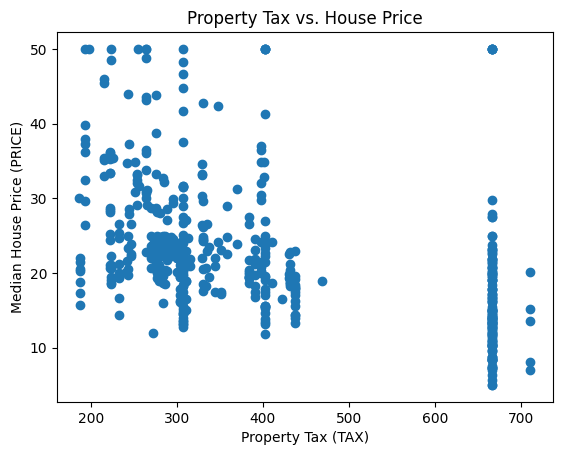

In [31]:
# Visualize the relationship between TAX and PRICE
plt.scatter(data['TAX'], data['PRICE'])
plt.xlabel('Property Tax (TAX)')
plt.ylabel('Median House Price (PRICE)')
plt.title('Property Tax vs. House Price')
plt.show()


There is a relationship between property tax (TAX) and house prices.
Areas with higher property taxes may have lower median house prices, indicating that property tax rates can affect housing affordability.

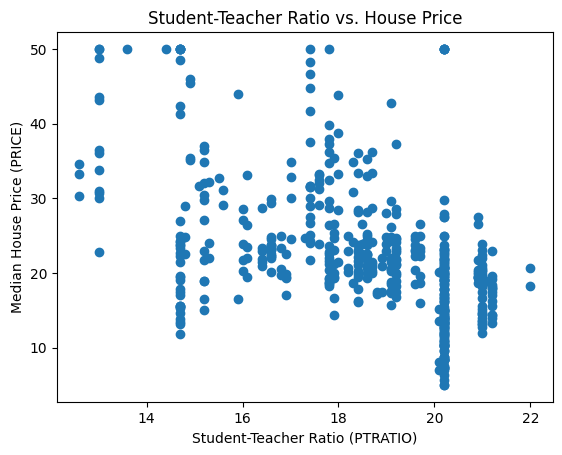

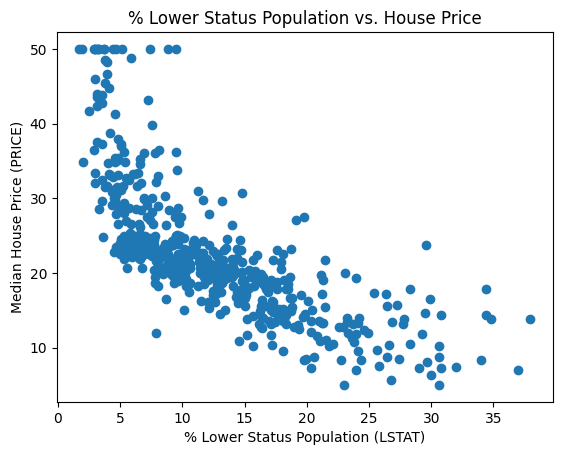

In [32]:
# Visualize the relationship between PTRATIO and PRICE
plt.scatter(data['PTRATIO'], data['PRICE'])
plt.xlabel('Student-Teacher Ratio (PTRATIO)')
plt.ylabel('Median House Price (PRICE)')
plt.title('Student-Teacher Ratio vs. House Price')
plt.show()

# Visualize the relationship between LSTAT and PRICE
plt.scatter(data['LSTAT'], data['PRICE'])
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median House Price (PRICE)')
plt.title('% Lower Status Population vs. House Price')
plt.show()


The dataset includes a variety of neighborhood-related features such as student-teacher ratio (PTRATIO) and percentage of lower-status population (LSTAT).
Higher student-teacher ratios (PTRATIO) are associated with lower house prices, possibly indicating that families are willing to pay more for areas with better educational resources.
Higher percentages of lower-status population (LSTAT) are associated with lower house prices, suggesting that socioeconomic factors influence property values.